# Register Utopia scenario with RLlib

In [1]:
import mobile_env
import gymnasium
from ray.tune.registry import register_env
import matplotlib.pyplot as plt
from IPython import display

# use the mobile-env RLlib wrapper for RLlib
def register(config):
    # importing mobile_env registers the included environments
    import mobile_env
    from mobile_env.wrappers.multi_agent import RLlibMAWrapper
    from mobile_env.wrappers.my_multi_agent import myRLlibMAWrapper

    env = gymnasium.make("mobile-utopia-custom_ma_handler-v0")
    return myRLlibMAWrapper(env)

# register my Custom scenario with RLlib
register_env("mobile-utopia-custom_ma_handler-v0", register)

# Render the environment

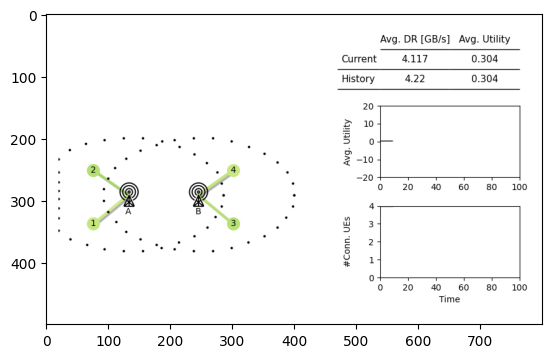

In [2]:
# init and render the custom scenario
env = gymnasium.make("mobile-utopia-custom_ma_handler-v0", render_mode="rgb_array")
env.reset()
for _ in range(10):
    # here, use random dummy actions by sampling from the action space
    dummy_action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(dummy_action)

    # render environment as RGB
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

Import RayLib

In [3]:
import ray


# init ray with available CPUs (and GPUs) and init ray
ray.init(
  num_cpus=2,   # change to your available number of CPUs
  include_dashboard=False,
  ignore_reinit_error=False,
  log_to_driver=False,
)
# !pip install ray[rllib]==2.5.1

2023-12-07 10:28:18,270	INFO worker.py:1673 -- Started a local Ray instance.


Python version:,3.10.13
Ray version:,2.8.0


In [ ]:
import ray.air
from ray.rllib.algorithms.ppo import PPOConfig

from ray.rllib.policy.policy import PolicySpec
from ray.tune.stopper import MaximumIterationStopper

# Create an RLlib config using multi-agent PPO on mobile-env's small scenario.
config = (
    PPOConfig()
    .environment(env="mobile-utopia-custom_ma_handler-v0")
    # Here, we configure all agents to share the same policy.
    .multi_agent(
        policies={"shared_policy": PolicySpec()},
        policy_mapping_fn=lambda agent_id, episode, worker, **kwargs: "shared_policy",
    )
    # RLlib needs +1 CPU than configured below (for the driver/traininer?)
    .resources(num_cpus_per_worker=1)
    .rollouts(num_rollout_workers=1)
)

# Create the Trainer/Tuner and define how long to train
tuner = ray.tune.Tuner(
    "PPO",
    run_config=ray.air.RunConfig(
        # Save the training progress and checkpoints locally under the specified subfolder.
        storage_path="C:\\Users\\vkout\\ray_results",
        # Control training length by setting the number of iterations. 1 iter = 4000 time steps by default.
        stop=MaximumIterationStopper(max_iter=5),
        checkpoint_config=ray.air.CheckpointConfig(checkpoint_at_end=True),
    ),
    param_space=config,
)

# Run training and save the result
result_grid = tuner.fit()

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir results_rllib

# Load and Test the trained Multi-Agent policy

Load the new trained policy

In [4]:
from ray.rllib.algorithms.algorithm import Algorithm

# load the trained agent from the stored checkpoint
best_result = result_grid.get_best_result(metric="episode_reward_mean", mode="max")
ppo = Algorithm.from_checkpoint(best_result.checkpoint)

NameError: name 'result_grid' is not defined

Test the new trained policy

In [ ]:
# import mobile_env
# import matplotlib.pyplot as plt
# from IPython import display

# # create the env for testing
# # pass rgb_array as render mode so the env can be rendered inside the notebook
# env = gymnasium.make("mobile-utopia-ma-v0", render_mode="rgb_array")
# obs, info = env.reset()
# done = False

# # run one episode with the trained model
# while not done:
#     # gather action from each actor (for each UE)
#     action = {}
#     for agent_id, agent_obs in obs.items():
#         # compute the action for the given agent using the shared policy
#         action[agent_id] = ppo.compute_single_action(agent_obs, policy_id="shared_policy")

#     # apply actions and perform step on simulation environment
#     obs, reward, terminated, truncated, info = env.step(action)
#     done = terminated or truncated

#     # render environment as RGB
#     plt.imshow(env.render())
#     display.display(plt.gcf())
#     display.clear_output(wait=True)

# Store Observations, Actions, Reward 

In [6]:
import pandas as pd
import gymnasium
import mobile_env
import matplotlib.pyplot as plt
from IPython import display

# Create the env for testing
env = gymnasium.make("mobile-utopia-custom_ma_handler-v0", render_mode="rgb_array")
obs, info = env.reset()
done = False

# Initialize an empty DataFrame to store results
results = pd.DataFrame(columns=["Agent_ID", "Observation", "Action", "Reward"])
row_index = 0  # Initial row index for the DataFrame

# Run one episode with the trained model
while not done:
    action = {}
    for agent_id, agent_obs in obs.items():
        # Compute the action for the given agent using the shared policy
        action[agent_id] = ppo.compute_single_action(agent_obs, policy_id="shared_policy")
    # Apply actions and perform step on simulation environment
    obs, rewards, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # Store the results in the DataFrame
    for agent_id, agent_action in action.items():
        agent_obs = obs.get(agent_id, None)
        agent_reward = rewards.get(agent_id, None)  # Safely get reward for the agent
        results.loc[row_index] = [agent_id, agent_obs, agent_action, agent_reward]
        row_index += 1  # Increment the row index

#     # Render environment as RGB
#     plt.imshow(env.render())
#     display.display(plt.gcf())
#     display.clear_output(wait=True)

# Specify the filename for the CSV file
filename = "results.csv"  # Update with your desired path

# Save the DataFrame to a CSV file
results.to_csv(filename, index=False)

print(f"Results saved to {filename}")
print(results.head)

C:\Users\vkout\anaconda3\envs\project\lib\site-packages\gymnasium\utils\passive_env_checker.py:275: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'dict'>
  logger.warn(


Results saved to results.csv
<bound method NDFrame.head of      Agent_ID       Observation  Action    Reward
0           1        [0.0, 0.0]       1  5.000000
1           2        [0.0, 0.0]       1  5.000000
2           3        [0.0, 0.0]       1  5.000000
3           4        [0.0, 0.0]       1  5.000000
4           1  [2.4124804, 2.5]       1  4.879376
..        ...               ...     ...       ...
395         4   [0.0, 9.827937]       1  5.000000
396         1  [0.0, 7.0922937]       1  5.000000
397         2   [0.0, 9.827937]       1  5.000000
398         3      [100.0, 0.0]       0  0.000000
399         4   [0.0, 9.827937]       1  5.000000

[400 rows x 4 columns]>


# Registering QMIX environment to RLIB

In [ ]:
# use the mobile-env RLlib wrapper for RLlib
def register(config):
    # importing mobile_env registers the included environments
    import mobile_env
    from mobile_env.wrappers.my_qmix_multi_agent_wrapper import myQMIXRLlibMAWrapper

    env = gymnasium.make("mobile-utopia-custom_ma_handler-v0")
    rlib_env = myQMIXRLlibMAWrapper(env)
    
    grouping = {
        "group_1": [1, 3],
        "group_2": [2, 4]
        }
    grouped_observation_space = gymnasium.spaces.Tuple([rlib_env.observation_space, rlib_env.observation_space])
    grouped_action_space = gymnasium.spaces.Tuple([rlib_env.action_space, rlib_env.action_space])

    grouped_env = rlib_env.with_agent_groups(grouping, obs_space=grouped_observation_space, act_space=grouped_action_space)
    return grouped_env

# register my Custom scenario with RLlib
register_env("mobile-QMIX-utopia-custom_ma_handler-v0", register)

# Using QMIX algorithm

In [ ]:
import ray.air
from ray.rllib.algorithms.qmix import QMixConfig

from ray.rllib.policy.policy import PolicySpec
from ray.tune.stopper import MaximumIterationStopper

# Create an RLlib config using multi-agent PPO on mobile-env's small scenario.
config = (
    QMixConfig()
    .environment(env="mobile-QMIX-utopia-custom_ma_handler-v0")
    # Here, we configure all agents to share the same policy.
    .multi_agent(
        policies={"shared_policy": PolicySpec()},
        policy_mapping_fn=lambda agent_id, episode, worker, **kwargs: "shared_policy",
    )
    # RLlib needs +1 CPU than configured below (for the driver/traininer?)
    .resources(num_cpus_per_worker=1)
    .rollouts(num_rollout_workers=1)
)

# Create the Trainer/Tuner and define how long to train
tuner = ray.tune.Tuner(
    "QMIX",
    run_config=ray.air.RunConfig(
        # Save the training progress and checkpoints locally under the specified subfolder.
        storage_path="C:\\Users\\vkout\\ray_results",
        # Control training length by setting the number of iterations. 1 iter = 4000 time steps by default.
        stop=MaximumIterationStopper(max_iter=5),
        checkpoint_config=ray.air.CheckpointConfig(checkpoint_at_end=True),
    ),
    param_space=config,
)

# Run training and save the result
result_grid = tuner.fit()

# Load and Test the trained Multi-Agent policy

In [ ]:
from ray.rllib.algorithms.algorithm import Algorithm

# load the trained agent from the stored checkpoint
best_result = result_grid.get_best_result(metric="episode_reward_mean", mode="max")
qmix = Algorithm.from_checkpoint(best_result.checkpoint)

# Store observations, actions, rewards using QMIX

In [ ]:
import pandas as pd
import gymnasium
import mobile_env
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from mobile_env.wrappers.my_qmix_multi_agent_wrapper import myQMIXRLlibMAWrapper


# Create the env for testing
env = gymnasium.make("mobile-utopia-custom_ma_handler-v0", render_mode="rgb_array")
rlib_env = myQMIXRLlibMAWrapper(env)  
grouping = {
    "group_1": [1, 3],
    "group_2": [2, 4]
    }
grouped_observation_space = gymnasium.spaces.Tuple([rlib_env.observation_space, rlib_env.observation_space])
grouped_action_space = gymnasium.spaces.Tuple([rlib_env.action_space, rlib_env.action_space])
env = rlib_env.with_agent_groups(grouping, obs_space=grouped_observation_space, act_space=grouped_action_space)
obs, info = env.reset()

print(obs.items())
res = qmix.compute_single_action(obs.items, policy_id="shared_policy")


done = False

# Initialize an empty DataFrame to store results
results = pd.DataFrame(columns=["Agent_ID", "Observation", "Action", "Reward"])
row_index = 0  # Initial row index for the DataFrame

# Run one episode with the trained model
while not done:
    action = {}
    for agent_id, agent_obs in obs.items():
        action[agent_id] = qmix.compute_single_action(agent_obs, policy_id="shared_policy")

    # Apply actions and perform step on simulation environment
    obs, rewards, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # Store the results in the DataFrame
    for agent_id, agent_action in action.items():
        agent_obs = obs.get(agent_id, None)
        agent_reward = rewards.get(agent_id, None)  # Safely get reward for the agent
        results.loc[row_index] = [agent_id, agent_obs, agent_action, agent_reward]
        row_index += 1  # Increment the row index

# Save the DataFrame to a CSV file
filename = "results2.csv"  # Update with your desired path
results.to_csv(filename, index=False)

print(f"Results saved to {filename}")
print(results.head())